In [1]:
import torch
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from torch.nn import MSELoss

from torch.utils.data.dataset import TensorDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler
from torch import Tensor, nn

from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

from itertools import chain

from traitlets import Callable

from koopman.simulation.simulator import simulate_batch
from koopman.simulation.systems import Pendulum

In [2]:
def generate_random_smooth_controls(N, T):
    dt = 0.05
    w = np.random.randn(N, T, 1) * np.sqrt(dt)
    b = np.cumsum(w, axis=1)
    b_smooth = gaussian_filter1d(b, sigma=10, axis=1)

    return b_smooth

In [20]:
params = Pendulum.Params(
    m=1, l=1, g=9.81, b=0.0
)

pendulum = Pendulum(params)

tf = 5.0
dt = 0.05
N = 1_000_000

theta0 = np.random.uniform(-np.pi, np.pi, (N, 1))
omega0 = np.random.uniform(-3, 3, (N, 1))
x0 = np.hstack((theta0, omega0))

U = generate_random_smooth_controls(N, int(tf/dt))
U = np.zeros_like(U)

ts, xhist_, uhist = simulate_batch(
    sys=pendulum,
    tf=tf,
    dt=dt,
    u=U,
    x0=x0
)

# parametrize theta as sin(theta), cos(theta)
xhist = np.zeros((xhist_.shape[0], xhist_.shape[1], 3))
xhist[..., 0] = np.sin(xhist_[..., 0])
xhist[..., 1] = np.cos(xhist_[..., 0])
xhist[..., 2] = xhist_[..., 1]

split = 0.9
N_train = int(N * split)
N_eval = N - N_train


xhist_train, uhist_train = xhist[:N_train], uhist[:N_train]
xhist_eval, uhist_eval = xhist[N_train:], uhist[N_train:]



Simulation progress: 100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


In [21]:
# Prepare training
traj_per_batch = 1024

dataset_train = TensorDataset(torch.tensor(xhist_train, dtype=torch.float32),
                              torch.tensor(uhist_train, dtype=torch.float32))
dataset_eval = TensorDataset(torch.tensor(xhist_eval, dtype=torch.float32),
                             torch.tensor(uhist_eval, dtype=torch.float32))

dataloader_train = DataLoader(dataset_train,
                              batch_size=traj_per_batch,
                              shuffle=True)
dataloader_eval = DataLoader(dataset_eval,
                             batch_size=traj_per_batch,
                             shuffle=False)

reconstruction_loss = MSELoss()
evolution_loss = MSELoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self, nx, nz, n_hidden=None):
        super().__init__()
        if n_hidden is None:
            n_hidden = nz
        self.nx, self.nz, self.n_hidden = nx, nz, n_hidden
        self.encoder = nn.Sequential(
            nn.Linear(nx, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, nz),
        )
        self.decoder = nn.Sequential(
            nn.Linear(nz, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, nx)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

In [23]:
# Trajectory rollout loss
mse_loss = MSELoss()

def rollout(zx0: Tensor, Zu: Tensor, A: Tensor, B: Tensor, Cs: None | Tensor = None) -> Tensor:
    N, nx = zx0.shape
    assert Zu.shape[0] == N
    _, traj_len, nu = Zu.shape
    traj_len += 1
    assert A.shape == (nx, nx)
    assert B.shape == (nx, nu)
    if Cs is not None:
        raise NotImplementedError

    Zx = torch.empty((N, traj_len, nx), dtype=zx0.dtype, device=zx0.device)
    Zx[:, 0, :] = zx0
    zxi = zx0
    for i in range(traj_len-1):
        zxi = torch.einsum('ml,Nl->Nm', A, zxi) + torch.einsum('ml,Nl->Nm', B, Zu[:, i, :])
        Zx[:, i+1, :] = zxi

    return Zx

def compute_rollout_loss(Zx_ref: Tensor, Zu: Tensor, A: Tensor, B: Tensor, n_segments: int, loss: Callable, discount: float = 1.0, Cs: None | Tensor = None) -> Tensor:
    N, traj_len, nz_x = Zx_ref.shape
    traj_len -= 1
    assert len(Zu.shape) == 3 and Zu.shape[0] == N and Zu.shape[1] == traj_len
    _, _, nz_u = Zu.shape
    if Cs is not None:
        raise NotImplementedError

    seg_len = traj_len // n_segments
    assert seg_len >= 2

    total_loss = torch.tensor(0.0, device=device)

    # collapse segment and batch dimensions
    Zx_ref_batched = Zx_ref[:, :n_segments*seg_len, :]
    Zu_batched = Zu[:, :n_segments*seg_len, :]
    Zx_ref_batched = Zx_ref_batched.reshape(-1, seg_len, nz_x)
    Zu_batched = Zu_batched.reshape(-1, seg_len, nz_u)

    zx0 = Zx_ref_batched[:, 0, :]
    Zx_rollout = rollout(zx0, Zu_batched, A, B, Cs)
    # apply loss
    for i in range(1, seg_len):
        total_loss += loss(Zx_rollout[:, i, :], Zx_ref_batched[:, i, :]) * discount ** i

    return total_loss


In [ ]:
from torch import optim

# Train
n_epochs = 10
nx, nu = 3, 1
nz_x = 50
nz_u = 50
n_rollout_segments = 1

A = torch.nn.Parameter(torch.eye(nz_x, dtype=torch.float32).to(device))
B = torch.nn.Parameter(torch.zeros((nz_x, nz_u), dtype=torch.float32).to(device))
autoenc_x = AutoEncoder(nx, nz_x).to(device)
autoenc_u = AutoEncoder(nu, nz_u).to(device)

# Cs = list()
# for i in range(nu):
#     Ci = torch.nn.Linear(nz_x, nz_u, bias=False).to(device)
#     nn.init.zeros_(Ci)
#     Cs.append(Ci)


theta = list(autoenc_x.parameters()) + list(autoenc_u.parameters())  + [A, B]
              # [Ci.parameters() for Ci in Cs])

optimizer = optim.Adam(theta, lr=1e-4)

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    iterator = tqdm(dataloader_train, total=len(dataloader_train) - 1, desc="Training")
    train_loss = 0.0
    for batch_idx, (x, u) in enumerate(iterator):
        # x: (batch_size, traj_len+1, nx)
        N = x.shape[0]
        x, u = x.to(device), u.to(device)
        x, u = torch.reshape(x, (-1, nx)), torch.reshape(u, (-1, nu))

        optimizer.zero_grad()

        zx = autoenc_x.encode(x)
        zu = autoenc_u.encode(u)
        x_rec = autoenc_x.decode(zx)
        u_rec = autoenc_u.decode(zu)

        reconstr_loss_x = mse_loss(x, x_rec)
        reconstr_loss_u = mse_loss(u, u_rec)

        zx = zx.reshape((N, -1, nz_x))
        zu = zu.reshape((N, -1, nz_u))

        rollout_loss = compute_rollout_loss(zx, zu, A, B, n_rollout_segments, mse_loss)

        loss = 2*reconstr_loss_x + 2*reconstr_loss_u + rollout_loss
        train_loss += loss.item()
        loss.backward()

        optimizer.step()

    train_loss /= len(dataloader_train)

    iterator = tqdm(dataloader_eval, total=len(dataloader_eval) - 1, desc="Eval")
    eval_reconstr_loss_x = 0.0
    eval_reconstr_loss_u = 0.0
    eval_rollout_loss = 0.0
    eval_loss = 0.0

    print(f"Train epoch {epoch+1}, L_reconstr,x: {reconstr_loss_x.item():.4f}, "
          f"L_reconstr,u: {reconstr_loss_u.item():.4f}, ",
          f"L_rollout: {rollout_loss.item():.4f}, ",
          f"L_total: {train_loss:.4f}")

    with torch.no_grad():
        for batch_idx, (x, u) in enumerate(iterator):
            N = x.shape[0]
            x, u = x.to(device), u.to(device)
            x, u = torch.reshape(x, (-1, nx)), torch.reshape(u, (-1, nu))

            optimizer.zero_grad()

            zx = autoenc_x.encode(x)
            zu = autoenc_u.encode(u)
            x_rec = autoenc_x.decode(zx)
            u_rec = autoenc_u.decode(zu)

            reconstr_loss_x = mse_loss(x, x_rec)
            reconstr_loss_u = mse_loss(u, u_rec)

            zx = zx.reshape((N, -1, nz_x))
            zu = zu.reshape((N, -1, nz_u))

            rollout_loss = compute_rollout_loss(zx, zu, A, B, n_rollout_segments, mse_loss)

            eval_loss += 2*reconstr_loss_x + 2*reconstr_loss_u + rollout_loss
            eval_reconstr_loss_x += reconstr_loss_x
            eval_reconstr_loss_u += reconstr_loss_u
            eval_rollout_loss += rollout_loss

    eval_reconstr_loss_x /= len(dataloader_eval)
    eval_reconstr_loss_u /= len(dataloader_eval)
    eval_rollout_loss /= len(dataloader_eval)
    eval_loss /= len(dataloader_eval)

    print(f"Eval epoch {epoch+1}, L_reconstr,x: {eval_reconstr_loss_x:.4f}, "
          f"L_reconstr,u: {eval_reconstr_loss_u:.4f}, ",
          f"L_rollout: {eval_rollout_loss:.4f}, ",
          f"L_total: {eval_loss:.4f}")

    for t, name in [(A, "A"), (B, "B")]:
        u, s, v = torch.linalg.svd(t)
        cond_number = s.max() / s.min()
        print(f"Cond {name}: {cond_number:.4f}")



Epoch 1/10


Training: 879it [01:30,  9.67it/s]                         
Eval:   4%|▍         | 4/97 [00:00<00:02, 36.97it/s]

Train epoch 1, L_reconstr,x: 0.2073, L_reconstr,u: 0.0000,  L_rollout: 0.1445,  L_total: 3.1114


Eval: 98it [00:02, 34.80it/s]                        


Eval epoch 1, L_reconstr,x: 0.2064, L_reconstr,u: 0.0000,  L_rollout: 0.1448,  L_total: 0.5577
Cond A: 1.2048
Cond B: 42396320.0000
Epoch 2/10


Training: 879it [01:33,  9.45it/s]                         
Eval:   4%|▍         | 4/97 [00:00<00:02, 36.50it/s]

Train epoch 2, L_reconstr,x: 0.0029, L_reconstr,u: 0.0000,  L_rollout: 0.0649,  L_total: 0.2021


Eval: 98it [00:02, 34.58it/s]                        


Eval epoch 2, L_reconstr,x: 0.0028, L_reconstr,u: 0.0000,  L_rollout: 0.0640,  L_total: 0.0697
Cond A: 1.2375
Cond B: 7535158.0000
Epoch 3/10


Training: 879it [01:34,  9.31it/s]                         
Eval:   4%|▍         | 4/97 [00:00<00:02, 35.50it/s]

Train epoch 3, L_reconstr,x: 0.0008, L_reconstr,u: 0.0000,  L_rollout: 0.0337,  L_total: 0.0500


Eval: 98it [00:02, 35.68it/s]                        


Eval epoch 3, L_reconstr,x: 0.0008, L_reconstr,u: 0.0000,  L_rollout: 0.0346,  L_total: 0.0363
Cond A: 1.2804
Cond B: 17229580.0000
Epoch 4/10


Training: 879it [01:37,  8.99it/s]                         
Eval:   4%|▍         | 4/97 [00:00<00:02, 31.70it/s]

Train epoch 4, L_reconstr,x: 0.0004, L_reconstr,u: 0.0000,  L_rollout: 0.0207,  L_total: 0.0285


Eval: 98it [00:03, 29.71it/s]                        


Eval epoch 4, L_reconstr,x: 0.0004, L_reconstr,u: 0.0000,  L_rollout: 0.0215,  L_total: 0.0224
Cond A: 1.3056
Cond B: 9155913.0000
Epoch 5/10


Training: 879it [01:35,  9.16it/s]                         
Eval:   0%|          | 0/97 [00:00<?, ?it/s]

Train epoch 5, L_reconstr,x: 0.0007, L_reconstr,u: 0.0000,  L_rollout: 0.0247,  L_total: 0.0188


Eval: 98it [00:02, 34.26it/s]                        


Eval epoch 5, L_reconstr,x: 0.0011, L_reconstr,u: 0.0000,  L_rollout: 0.0166,  L_total: 0.0188
Cond A: 1.3111
Cond B: 5387801.0000
Epoch 6/10


Training: 879it [01:36,  9.12it/s]                         
Eval:   4%|▍         | 4/97 [00:00<00:02, 36.45it/s]

Train epoch 6, L_reconstr,x: 0.0002, L_reconstr,u: 0.0000,  L_rollout: 0.0110,  L_total: 0.0138


Eval: 98it [00:02, 34.25it/s]                        


Eval epoch 6, L_reconstr,x: 0.0002, L_reconstr,u: 0.0000,  L_rollout: 0.0112,  L_total: 0.0117
Cond A: 1.3247
Cond B: 2088948.0000
Epoch 7/10


Training:  69%|██████▉   | 604/878 [01:04<00:27, 10.06it/s]

In [ ]:
# pick sample trajectory

with torch.no_grad():
    idx = np.arange(10)

    test_xhist = torch.tensor(xhist_train[idx], dtype=torch.float32).to(device)
    test_uhist = torch.tensor(uhist_train[idx], dtype=torch.float32).to(device)

    zx = autoenc_x.encode(test_xhist[:, 0, :])

    test_xhist_pred = torch.empty_like(test_xhist)
    test_xhist_pred[:, 0, :] = autoenc_x.decode(zx)

    for i, t in enumerate(ts[:-1]):
        zu = autoenc_u.encode(test_uhist[:, i, :])
        zxp = torch.einsum('ml,Nl->Nm', A, zx) + torch.einsum('ml,Nl->Nm', B, zu)
        test_xhist_pred[:, i + 1, :] = autoenc_x.decode(zxp)
        zx = zxp

    test_xhist_pred_np = test_xhist_pred.cpu().numpy()
    test_uhist_np = test_uhist.cpu().numpy()
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()

print(f"Rank A: {np.linalg.matrix_rank(A_np)}, Cond A {np.linalg.cond(A_np)}")
print(f"Rank B: {np.linalg.matrix_rank(B_np)}, Cond B {np.linalg.cond(B_np)}")

Rank A: 50, Cond A 1.14732027053833
Rank B: 50, Cond B 130805.4765625


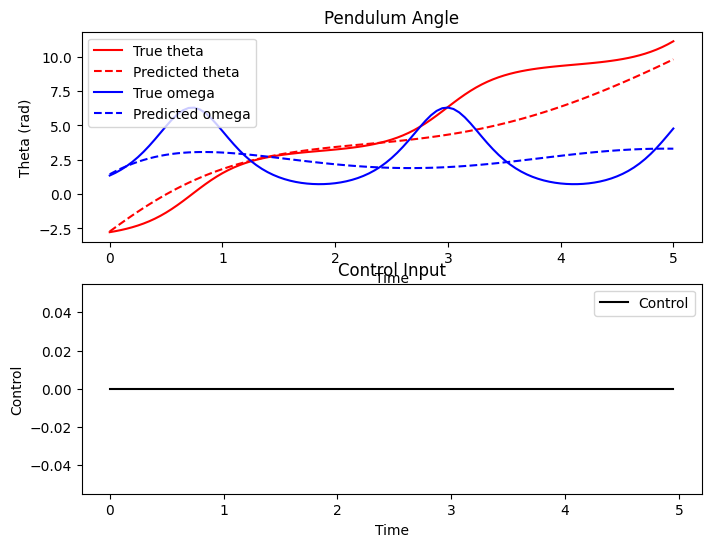

In [ ]:
i = 5

def unwrap_angle(arr: np.ndarray) ->  np.ndarray:
    shape = list(arr.shape)
    assert shape[-1] == 2
    shape[-1] = 1
    res = np.empty(shape, dtype=arr.dtype)
    res[..., 0] = np.arctan2(arr[..., 0], arr[..., 1])
    return res

test_xhist_np = test_xhist.cpu().numpy()
test_xhist_np = np.stack((unwrap_angle(test_xhist_np[:2]), test_xhist_np[[2, ]])
test_xhist_plt, test_uhist_plt, test_xhist_pred_plt = test_xhist_np[i, :],  test_uhist_np[i, :], test_xhist_pred_np[i, :]
test_xhist_pred_plt = np.clip(test_xhist_pred_plt, -10, 10)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
# ax[0].plot(eval_ts, angle_wrap(eval_xhist[:, 0], "-pi:pi"), color='red', label="True theta")
# ax[0].plot(eval_ts, angle_wrap(eval_xhist_pred[:, 0], "-pi:pi"), color='red', label="Predicted theta", linestyle='--')
ax[0].plot(ts, test_xhist_plt[:, 0], color='red', label="True theta")
ax[0].plot(ts, test_xhist_pred_plt[:, 0], color='red', label="Predicted theta", linestyle='--')
ax[0].plot(ts, test_xhist_plt[:, 1], color='blue', label="True omega")
ax[0].plot(ts, test_xhist_pred_plt[:, 1], color='blue', label="Predicted omega", linestyle='--')
ax[0].set_title("Pendulum Angle")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Theta (rad)")
ax[0].legend()

ax[1].plot(ts[:-1], test_uhist_plt[:, 0], color='black', label="Control")
ax[1].set_title("Control Input")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Control")
ax[1].legend()

